# References
* Data source: https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/
* Sample/starter code: https://github.com/alik604/cyber-security/blob/master/Intrusion-Detection/UNSW_NB15.ipynb

In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

from keras import Sequential
from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras import regularizers

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize


import xgboost, lightgbm
from mlxtend.classifier import EnsembleVoteClassifier

# Loading data from GitHub

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/ushukkla/nospammers/master/UNSW_NB15_training-set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/ushukkla/nospammers/master/UNSW_NB15_testing-set.csv')
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

In [3]:
train.shape, test.shape

((82332, 45), (175341, 45))

In [4]:
# Dividing the train data into attack and non-attack category
normal = train[train['label']==0]
anomaly = train[train['label']==1]

# Utility Functions

In [26]:
def col_countplot(col, train_data=train):
    """
    This function plots countplot of a given feature for train dataset
    """
    fig, ax = plt.subplots(figsize=(8,4))
    sns.set_style('whitegrid')
    # countplot of the given column
    ax = sns.countplot(x=col, hue='label', data=train_data)
    ax.legend(loc="upper right", labels=('normal', 'attack'))
    ax.set_title("train data")
    plt.xticks(rotation=45)
    plt.show()

In [27]:
def col_countplot(col, train_data=train):
    """
    This function plots countplot of a given feature for train dataset
    """
    fig, ax = plt.subplots(figsize=(8,4))
    sns.set_style('whitegrid')
    # countplot of the given column
    ax = sns.countplot(x=col, hue='label', data=train_data)
    ax.legend(loc="upper right", labels=('normal', 'attack'))
    ax.set_title("train data")
    plt.xticks(rotation=45)
    plt.show()

In [28]:
def reduce_column(s, to_keep):
    """
    This function reduce categorical values of a given feature to values provided in to_keep list
    and make every other value "others"
    """
    s = s.lower().strip()
    if s not in to_keep:
        return "others"
    else:
        return s

# Visualization
## 1. Attack
### 1.1 Distribution bar chart.
Getting distribution of for all the attacks.  
Plot bar char and pie chart of distribution for better visualization

<BarContainer object of 10 artists>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

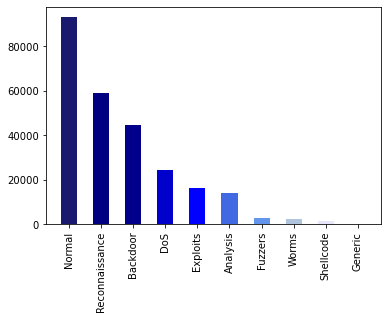

In [12]:
plt.bar(combined_data.attack_cat.unique(),
        combined_data.attack_cat.value_counts(), 
        width=0.5, 
        bottom=None, 
        align='center', 
        color=['midnightblue',
               'navy',
               'darkblue',
               'mediumblue',
               'blue', 
               'royalblue', 
               'cornflowerblue', 
               'lightsteelblue', 
               'lavender', 
               'lightskyblue'])
plt.xticks(rotation='vertical')
plt.savefig('distribution_bar_chart.png')
plt.show()

### 1.2 Distribution pie chart.

([<matplotlib.patches.Wedge at 0x7fca3c986490>,
 [Text(0.4654704967072229, 0.996663040698877, 'Normal'),
  Text(-1.0866279471333316, 0.1709962119720845, 'Reconnaissance'),
  Text(-0.4945025009453456, -0.9825819439409615, 'Backdoor'),
  Text(0.40004113575353367, -1.0246790178904919, 'DoS'),
  Text(0.8387714234046985, -0.7116617871430616, 'Exploits'),
  Text(1.0393251377247725, -0.3602821923067843, 'Analysis'),
  Text(1.090644197435221, -0.14316156816996317, 'Fuzzers'),
  Text(1.097345720968709, -0.07636994612846441, 'Worms'),
  Text(1.0997174710924, -0.024929576292758538, 'Shellcode'),
  Text(1.0999975248432161, -0.0023335249727840894, 'Generic')],
 [Text(0.25389299820393973, 0.5436343858357511, '36.09%'),
  Text(-0.5927061529818171, 0.09327066107568245, '22.85%'),
  Text(-0.2697286368792794, -0.5359537876041608, '17.28%'),
  Text(0.2182042558655638, -0.5589158279402682, '9.41%'),
  Text(0.4575116854934718, -0.3881791566234881, '6.35%'),
  Text(0.5669046205771486, -0.19651755944006416, 

Text(0.5, 1.0, 'Distribution')

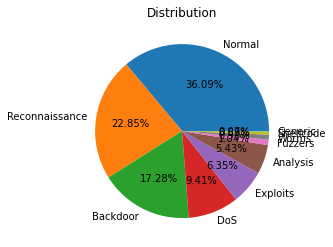

In [13]:
plt.pie(combined_data.attack_cat.value_counts(), labels=combined_data.attack_cat.unique(), autopct='%1.2f%%')
plt.title('Distribution')
plt.savefig('distribution_pie_chart.png')
plt.show()

### 1.3 Protocol
* The no of unique values of 'proto' in dataset where attack is normal is 7 but in anamoly category its 129. So to plot it we are reducing the no of values.
* Most of the values are consists of udp and tcp
* For non-attacks count of tcp is lot higher
* Considering the imbalce there are lots of udp cat for attacks

In [18]:
train['proto'].nunique()

131

In [19]:
normal['proto'].nunique(), anomaly['proto'].nunique()

(5, 129)

In [23]:
train['proto'].value_counts().head(10)*100/train.shape[0]

tcp     52.342953
udp     35.730943
unas     4.269300
arp      1.198805
ospf     0.821066
sctp     0.393529
any      0.116601
gre      0.106884
rsvp     0.077734
ipv6     0.074090
Name: proto, dtype: float64

In [24]:
to_keep = ['tcp', 'udp', 'unas', 'arp', 'ospf']
train['proto_reduced'] = train['proto'].apply(reduce_column, args=(to_keep,))

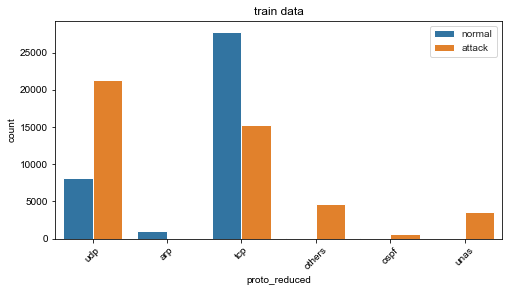

In [29]:
col_countplot('proto_reduced')

### 1.4 Service

* In our dataset we can value "-" that is null, we need to remove that and replace it.
* For normal there are lots of others that means most of "-" and few rare values.
* In attack data "dns" is present higher than any other values. There are few no of others and http also.

In [30]:
train['service'].nunique()

13

In [31]:

train['service'].value_counts()

-           47153
dns         21367
http         8287
smtp         1851
ftp          1552
ftp-data     1396
pop3          423
ssh           204
ssl            30
snmp           29
dhcp           26
radius          9
irc             5
Name: service, dtype: int64

In [32]:

to_keep = ['dns', 'http', 'smtp', 'ftp-data', 'ftp', 'ssh', 'pop3']
train['service_reduced'] = train['service'].apply(reduce_column, args=(to_keep,))

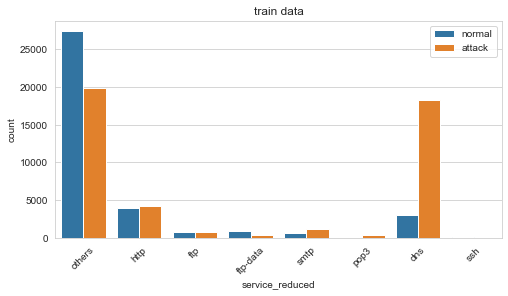

In [33]:
col_countplot('service_reduced')

## 2. Correlation
Getting correlation values for all the features.
Plot heatmap of correaltion for better visualization

In [14]:
def multi_corr(col1, col2="label", df=train):
    '''
    This function returns correlation between 2 given features.
    Also gives corr of the given features with "label" afetr applying log1p to it.
    '''
    corr = df[[col1, col2]].corr().iloc[0,1]
    log_corr = df[col1].apply(np.log1p).corr(df[col2])

    print("Correlation : {}\nlog_Correlation: {}".format(corr, log_corr))

In [15]:
def corr(col1, col2="label", df=train):
    """
    This function returns correlation between 2 given features
    """
    return df[[col1, col2]].corr().iloc[0,1]

<Figure size 864x864 with 0 Axes>

<AxesSubplot:>

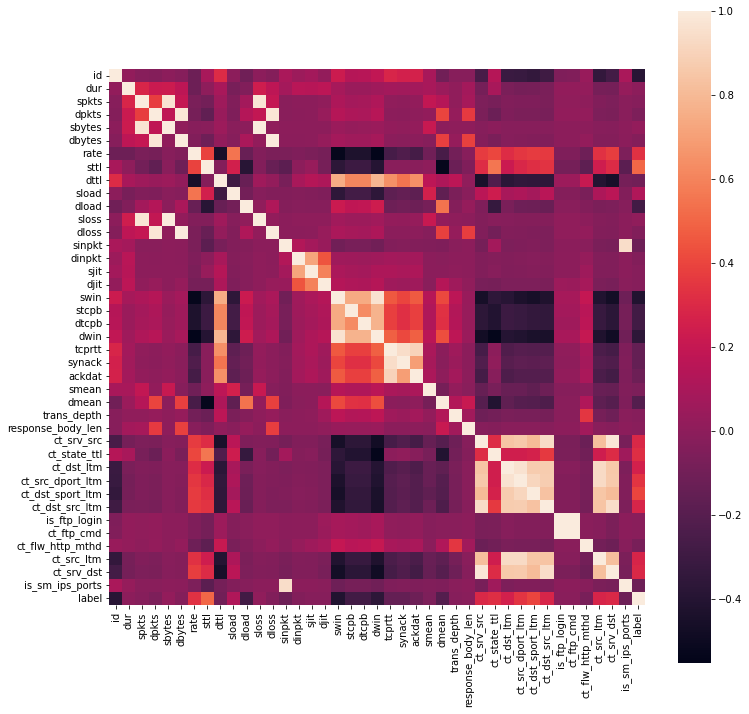

In [16]:

# Plotting the correlation matrix of the dataset
# Refer: https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf

method = "pearson"
# correlation matrix
corr_mat = train.corr(method=method)

plt.figure(figsize=(12,12)) 
sns.heatmap(corr_mat, square=True)
plt.show()

In [17]:
# Getting and printing high correlated features
limit = 0.9

columns = corr_mat.columns
for i in range(corr_mat.shape[0]):
    for j in range(i+1, corr_mat.shape[0]):
        if corr_mat.iloc[i, j] >= 0.9:
            print(f"{columns[i]:20s} {columns[j]:20s} {corr_mat.iloc[i, j]}")

spkts                sbytes               0.9657497410287414
spkts                sloss                0.9736439932787799
dpkts                dbytes               0.9764185516958216
dpkts                dloss                0.9815064328008422
sbytes               sloss                0.99502719113184
dbytes               dloss                0.9971088501020646
sinpkt               is_sm_ips_ports      0.9445057600994802
swin                 dwin                 0.9601246970559344
tcprtt               synack               0.9394732071062888
ct_srv_src           ct_dst_src_ltm       0.9337952137616565
ct_srv_src           ct_srv_dst           0.9778491535974652
ct_dst_ltm           ct_src_dport_ltm     0.9604008284955233
ct_dst_ltm           ct_src_ltm           0.9322524473427766
ct_src_dport_ltm     ct_dst_sport_ltm     0.9116374681078989
ct_src_dport_ltm     ct_src_ltm           0.9331720623302827
ct_dst_src_ltm       ct_srv_dst           0.9410468630509295
is_ftp_login         ct_ft

## Preprocessing

In [26]:
le1 = LabelEncoder()
le = LabelEncoder()

vector = combined_data['attack_cat']

print("attack cat:", set(list(vector))) # use print to make it print on single line 

combined_data['attack_cat'] = le1.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

vector = combined_data['attack_cat']
print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode(), "Which is,", le1.inverse_transform(vector.mode()))
print("mode", len(np.where(vector.values==6)[0])/len(vector)*100,"%")

attack cat: {'Analysis', 'Shellcode', 'Fuzzers', 'Worms', 'Backdoor', 'DoS', 'Exploits', 'Normal', 'Generic', 'Reconnaissance'}

Describing attack_type: 
min 0
max 9
mode 0    6
dtype: int64 Which is, ['Normal']
mode 36.09225646458884 %
